In [1]:
import os
import json

# Define the root directory where folders are located
root_directory = "elements"  # Change this to your actual root directory

# Initialize a list to store results
results = []

# Iterate through each folder in the root directory
for folder_name in os.listdir(root_directory):
    folder_path = os.path.join(root_directory, folder_name)
    
    if os.path.isdir(folder_path):
        code_content = None
        index_content = None
        description_content = None
        
        # Read Code.tsx file
        code_file_path = os.path.join(folder_path, "Code.tsx")
        if os.path.exists(code_file_path):
            with open(code_file_path, "r", encoding="utf-8") as file:
                code_content = file.read()
        
        # Read index.txt file
        index_file_path = os.path.join(folder_path, "index.txt")
        if os.path.exists(index_file_path):
            with open(index_file_path, "r", encoding="utf-8") as file:
                index_content = file.read()

        # Read description.txt file
        description_file_path = os.path.join(folder_path, "description.txt")
        if os.path.exists(description_file_path):
            with open(description_file_path, "r", encoding="utf-8") as file:
                description_content = file.read()
        
        # Append result to the list
        results.append({
            "elementType": folder_name,
            "code": code_content,
            "meta": index_content,
            "description": description_content
        })

# Save results to a JSON file
output_file = "output.json"
with open(output_file, "w", encoding="utf-8") as json_file:
    json.dump(results, json_file, ensure_ascii=False, indent=2)

print(f"JSON file '{output_file}' created successfully.")

JSON file 'output.json' created successfully.


In [2]:
import lancedb
import langchain
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import LanceDB
from langchain.chat_models import ChatOpenAI
from langgraph.graph import StateGraph, END, START
from langchain.schema import SystemMessage, HumanMessage
from typing import List, Dict
import logging


In [3]:
from langchain_openai import ChatOpenAI
import os
from pydantic import BaseModel, Field
from typing import Literal, Union
from langchain.chat_models import ChatOllama
import os

logging.basicConfig(format="%(asctime)s - %(message)s", level=logging.INFO)

azure_base_url = "https://models.inference.ai.azure.com"
together_base_url = "https://api.together.xyz/v1"
ollama_base_url = "http://localhost:11434"

github_token = os.environ["GITHUB_API_KEY"]

llm = ChatOpenAI(
    # model= "gpt-4o",
    model = "gpt-4o-mini",
    api_key= github_token,
    base_url= azure_base_url,
)

llama_llm = ChatOpenAI(
    model="meta-llama/Llama-3.3-70B-Instruct-Turbo",
    api_key=github_token,
    base_url=azure_base_url,
)

ollama_model = ChatOllama(
    model="llama3.2:latest", 
    base_url= ollama_base_url
)

class StateDefinition(BaseModel):
    name: str = Field(..., title="State Name")
    defaultValue: Union[str, int, bool, dict, list, None] = Field(None, title="Default Value")
    type: Literal["STRING", "NUMBER", "BOOLEAN", "OBJECT", "ARRAY"] = Field(..., title="Type of State")

class PropDefinition(BaseModel):
    name: str = Field(..., title="Prop Name")
    type: Literal["STRING", "NUMBER", "BOOLEAN", "OBJECT", "ARRAY", "FUNCTION"] = Field(..., title="Type of Prop")

class FunctionDefinition(BaseModel):
    name: str = Field(..., title="Function Name")
    inputParams: List[str] = Field(None, title="Input Parameters of Function")
    code: str = Field(..., title="Function code")

class ComponentDefinition(BaseModel):
    title: str = Field("", title="Component Title")
    description: str = Field("", title="Component Description")
    states: List[StateDefinition] = Field([], title="States used in Component")
    props: List[PropDefinition] = Field([], title="Props used in Component")
    functions: List[FunctionDefinition] = Field([], title="Functions used in Component")
    jsx_code: str = Field(..., title="jsx code of Component")
    component_code: str = Field(..., title="code of Component")
    elementTypes: List[str] = Field([], title="Element Types used in Component")

class TaskDefinition(BaseModel):
    title: str = Field(..., title="Task Title")
    result_task: ComponentDefinition = Field(None, title="Result Task")

# Define Agent State
class AgentState(BaseModel):
    query: str
    is_relevant: bool = True
    tasks: List[TaskDefinition] = []
    final_result: ComponentDefinition = None

C:\Users\Iranian\AppData\Local\Temp\ipykernel_12172\4211583416.py:29: LangChainDeprecationWarning: The class `ChatOllama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import ChatOllama``.
  ollama_model = ChatOllama(


In [4]:
# if you want to use the Gemma, you will need to authenticate with HuggingFace, Skip this step, if you have the model already downloaded
# from huggingface_hub import login
# login()

In [5]:
from lancedb.embeddings import get_registry
embedding_model = get_registry().get("sentence-transformers").create(name="BAAI/bge-small-en-v1.5")

#You should put HF_TOKEN in the Notebook enviroment variables
from lancedb.pydantic import LanceModel, Vector

# Connect to LanceDB (Vector Database for JSX Retrieval)
db = lancedb.connect(".lancedb")  
# vector_store = LanceDB(db, OpenAIEmbeddings())

data = []
# read data from output.json file
with open("output.json", "r", encoding="utf-8") as file:
    data = json.load(file)

class ChunksOfData(LanceModel):
    elementType: str = ""
    code: str | None = None  # Allow null values
    meta: str = ""
    description: str = embedding_model.SourceField()
    vector: Vector(embedding_model.ndims()) = embedding_model.VectorField()


tbl = db.create_table(
    "react_elements",
    data= data,
    schema=ChunksOfData,
    exist_ok=True,
    mode="overwrite"
)

2025-02-28 10:38:51,353 - Load pretrained SentenceTransformer: BAAI/bge-small-en-v1.5


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
tbl = db.open_table("react_elements")
query = "stepper"

res= tbl.search(query).limit(5).to_pandas()
res

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

,elementType,code,meta,description,vector,_distance
0,STEPER_CONTAINER,"import React, { HTMLAttributes, useEffect } fr...","{\n elementType: ""KdStepRoot"",\n children: [...",The StepperContainer component is a customizab...,"[-0.081205554, -0.016815962, 0.015941583, 0.08...",0.498129
1,STEPER_ELEMENT,"import React from ""react"";\nimport Stepper, { ...","{\n elementType: ""KdStepContent"",\n children...",The StepperElement component is a customizable...,"[-0.07910837, -0.005119668, 0.024634406, 0.075...",0.522580
2,DIVIDER,"import { Divider, DividerProps } from ""@mui/ma...","{\n elementType: ""KdpaDivider"",\n children: ...",The Divider component is a customizable divide...,"[-0.05971071, 0.013275463, 0.042954285, 0.0310...",0.838013
3,LAYOUT_ROW,"import React from ""react"";\nimport Grid, { Gri...","{\n elementType: ""KdpaGrid"",\n children: [],...",The LayoutRow component is a simple customizab...,"[-0.043467417, -0.0008123551, 0.049763795, -0....",0.871431
4,TAB_CONTAINER,"import * as Tabs from ""@radix-ui/react-tabs"";\...","{\n elementType: ""KdTabsRoot"",\n children: [...",The TabConatiner component is a customizable t...,"[-0.031779632, 0.052633706, 0.0034408066, 0.05...",0.908668


In [7]:
from pydantic import BaseModel, Field

class RelevantUserQuery(BaseModel):
    is_relevant : bool = Field(description="boolean for relevance or not")

# **Relevance Check Node**
def check_relevance(state: AgentState):
    prompt = f"Is the following request related to front-end UI component generation? \n\nQuery: {state.query}"
    
    structured_model = llm.with_structured_output(RelevantUserQuery)
    
    response = structured_model.invoke([SystemMessage(content="You determine if a query is relevant to UI development."),
                           HumanMessage(content=prompt)])
        
    logging.info(f"Relevance Check Response: {response.is_relevant}")
    
    state.is_relevant = response.is_relevant
    return state

In [8]:
from pydantic import BaseModel, Field

class TaskList(BaseModel):
    tasks : List[str] = Field(description="list of tasks")

# **Task Processing Node**
def process_query(state: AgentState):
    prompt = f"{state.query}"

    structured_model = llm.with_structured_output(TaskList)
    response = structured_model.invoke([SystemMessage(content="""You analyze UI queries and generate structured tasks.
                                                      you are assistant for craete react component code but in mullti step process.
                                                      you should generate each of tag element with style and attributes recursively.

                                                      for done this recursively you should the user query divide to some task and do it step by step.
                                                      now create sub task of user query for generate component code for each tag element recursively.
                                                      """),
                           HumanMessage(content=prompt)])
    
    logging.info(f"Task Processing Response: {response.tasks}\n ======================================= \n")
    state.tasks = [ {"title": task } for task in response.tasks]
    return state

In [9]:
from pydantic import BaseModel, Field, ValidationError

class JsxTask(BaseModel):
    jsx : str = Field(description=" string of jsx code")
    elementTypes : List[str] = Field(description="list of element types required in the jsx code")

# **Generate JSX Using LLM**
def generate_code(state: AgentState):
    for task in state.tasks:
        context = ''.join([f"elementType({c['elementType']}): {c['description']}\n\n" for c in data])

        prompt = f"""
        Task: {task.title}\n\n Context: {context}\n\n
        """
        structured_model = llm.with_structured_output(ComponentDefinition)
        
        response = structured_model.invoke([SystemMessage(content=""" you are great developer and you can create react component code.
                                                          You refine component react to match UI tasks. and list of element types used in JSX code
                                                          but my element is specific and you can not use any element.
                                                          in context exist my element with description and valid attribute, static attrs and dynamic attrs.
                                                          static attrs is fixed and can not use state or props or ... and dynamic attrs can be used from state or props or static or ... .
                                                          also can use style element in style attribute.       
                                                          now you should generate jsx code for this task with element types.
                                                          you can only use useState and props component and function in your code.
                                                          """),
                               HumanMessage(content=prompt)])
        
        try:
            logging.info("Generated component react for task '{}': \n{}".format(task.title, response))
            component = ComponentDefinition(**response.model_dump())
            newTask = TaskDefinition(title=task.title, result_task=component)
            state.tasks[state.tasks.index(task)] = newTask
        except ValidationError as exc:
            print(repr(exc.errors()[0]['type']))
            #> 'missing'
        
    
    return state

In [10]:
# **Merge All JSX into a Final Component**
def merge_code(state: AgentState):
    context = ''.join([f"elementType({c['elementType']}): {c['description']}\n\n" for c in data])

    tasksData = [{"title":task.title, "result_task": task.result_task.model_dump() if task.result_task else ""} for task in state.tasks]

    prompt = f"""the user query is: {state.query}.\n\n 
    at the first we break the user query to sub tasks and recusive generate component code for each of them, this is of sub task and
    
    generated sub tasks: {tasksData}.
    context: {context}.
    
    """
    
    structured_model = llm.with_structured_output(ComponentDefinition)
    response = structured_model.invoke([SystemMessage(content="""You are great developer and you can create react component code.
                                                      There was one query and divide that to some tasks and component react for each of them.
                                                      You should only use this sub task and component data and combine that for answer the main query in single react component.
                                                      but my element is specific and you can not use any element.
                                                          in context exist my element with description and valid attribute, static attrs and dynamic attrs.
                                                          static attrs is fixed and can not use state or props or ... and dynamic attrs can be used from state or props or static or ... .
                                                          also can use style element in style attribute.       
                                                      you can only use useState and props component and function in your code.
                                                      """),
                           HumanMessage(content=prompt)])

    state.final_result = ComponentDefinition(**response.model_dump())
    
    logging.info("Final Generated React components :\n {}".format(response))
    return state

In [11]:
# **Merge All JSX into a Final Component**
def generate_code_in_one_step(state: AgentState):
    context = ''.join([f"elementType({c['elementType']}): {c['description']}\n\n" for c in data])

    prompt = f"""the user query is: {state.query}.\n\n     
    context: {context}.
    """
    
    structured_model = llm.with_structured_output(ComponentDefinition)
    response = structured_model.invoke([SystemMessage(content="""You are great developer and you can create react component code.
                                                      you should generate jsx code for this task with element types.
                                                      but my element is specific and you can not use any element.
                                                          in context exist my element with description and valid attribute, static attrs and dynamic attrs.
                                                          static attrs is fixed and can not use state or props or ... and dynamic attrs can be used from state or props or static or ... .
                                                        also can use style element in style attribute.  
                                                        you can only use useState and props component and function in your code.
                                                      """),
                           HumanMessage(content=prompt)])

    state.final_result = ComponentDefinition(**response.model_dump())
    
    logging.info("Final Generated React components :\n {}".format(response))
    return state

In [12]:
from typing import Literal

def decide_mood(state) -> Literal["process_query", END]:
    # Often, we will use state to decide on the next node to visit
    if state.is_relevant == True:
        return "process_query"
    
    else:
        return END

In [13]:
# **Define Graph Workflow**
workflow = StateGraph(AgentState)

# Add Nodes
workflow.add_node("check_relevance", check_relevance)
workflow.add_node("process_query", process_query)
workflow.add_node("generate_code", generate_code)
workflow.add_node("merge_code", merge_code)

workflow.add_edge(START, "check_relevance")

# **Conditional Edge:**
workflow.add_conditional_edges(
    "check_relevance",  # From
    decide_mood
)

# Normal Edges
workflow.add_edge("process_query", "generate_code")
workflow.add_edge("generate_code", "merge_code")
workflow.add_edge("merge_code", END)

# Compile and Run
graph = workflow.compile()

In [14]:
from typing import Literal

def decide_mood2(state) -> Literal["generate_code_in_one_step", END]:
    # Often, we will use state to decide on the next node to visit
    if state.is_relevant == True:
        return "generate_code_in_one_step"
    
    else:
        return END

In [15]:
# **Define Graph Workflow**
workflow2 = StateGraph(AgentState)

# Add Nodes
workflow2.add_node("check_relevance", check_relevance)
workflow2.add_node("generate_code_in_one_step", generate_code_in_one_step)

workflow2.add_edge(START, "check_relevance")

# **Conditional Edge:**
workflow2.add_conditional_edges(
    "check_relevance",  # From
    decide_mood2
)

# Normal Edges
workflow2.add_edge("generate_code_in_one_step", END)

# Compile and Run
graph2 = workflow2.compile()

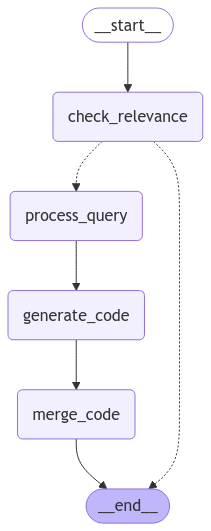

In [16]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

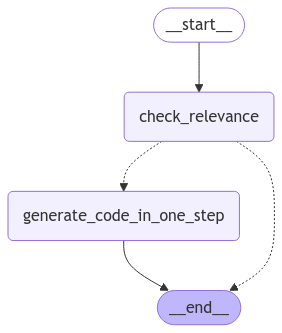

In [17]:
from IPython.display import Image, display
display(Image(graph2.get_graph().draw_mermaid_png()))

In [18]:
# i want have list of complex varius queries for test the model
queries = [
    """I want a beautifuly header:
                             in the right a image box have logo and title of website.
                             in the left many item link that each of them have a icon and text.
                             like : link to shoppage, link to about us page, link to contact us page.
                             and at the end of left side a button for login.""",
    """I want a form for register user:
                                have a input for username, email, password and repeat password.
                                also have a button for submit form.""",
    """I want a list of product:
                                have a image for each product, title of product, price of product and a button for add to cart.""",
    """I want a list of post:
                                have a image for each post, title of post, description of post and a button for read more.""",
]

In [21]:
initial_stateee = AgentState(query=queries[1])

res = graph2.invoke(initial_stateee)

2025-02-28 10:41:22,731 - HTTP Request: POST https://models.inference.ai.azure.com/chat/completions "HTTP/1.1 200 OK"
2025-02-28 10:41:22,737 - Relevance Check Response: True
2025-02-28 10:41:52,476 - HTTP Request: POST https://models.inference.ai.azure.com/chat/completions "HTTP/1.1 200 OK"
2025-02-28 10:41:52,481 - Final Generated React components :
 title='User Registration Form' description='A form for registering a new user with inputs for username, email, password, and repeat password, along with a submit button.' states=[StateDefinition(name='username', defaultValue='', type='STRING'), StateDefinition(name='email', defaultValue='', type='STRING'), StateDefinition(name='password', defaultValue='', type='STRING'), StateDefinition(name='repeatPassword', defaultValue='', type='STRING'), StateDefinition(name='loading', defaultValue=False, type='BOOLEAN')] props=[PropDefinition(name='onSubmit', type='FUNCTION')] functions=[] jsx_code="<KdFormLoader loading={loading} errorMode='onSubmi

In [22]:
agent_state = AgentState(**res)

with open("agent_state2.json", "w", encoding="utf-8") as f:
    f.write(agent_state.model_dump_json(indent=4))

with open("Component2.jsx", "w", encoding="utf-8") as f:
    f.write(agent_state.final_result.component_code)
